In [2]:
# standard library
import os
from os import path
import sys
_path = path.abspath('../pkg/')
if _path not in sys.path:
    sys.path.append(_path)
import pickle

# Third-party
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
import corner
from schwimmbad import MultiPool, SerialPool

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import UnitSystem

import emcee
from pyia import GaiaData

from chemtrails.potential import Sech2Potential, UniformPotential
from chemtrails.likelihood import Model
from chemtrails.data import (load_nominal_galah, load_nominal_apogee, 
                             get_abundance_data, get_label_from_abundancename)

In [3]:
usys = UnitSystem(u.pc, u.Myr, u.Msun, u.radian, u.km/u.s)

# GALAH

In [ ]:
g, galcen = load_nominal_galah('/Users/adrian/data/GaiaDR2/GALAH-GaiaDR2-xmatch.fits')
len(g)

---

## Emcee

In [6]:
p0 = np.array([0., 0.,
               np.log(65), np.log(250),
               np.log(0.2**2), 
               0., 0., -0.2, 0.05])

nwalkers = 64
ndim = len(p0)
p0 = emcee.utils.sample_ball(p0, std=[1e-2, 1e-2,
                                      1e-2, 1e-2,
                                      1e-3, 
                                      1e-4, 1e-4, 1e-4, 1e-4], size=nwalkers)

In [7]:
all_elems = []
for col in g.data.colnames:
    if (col.endswith('_fe') and not col.startswith('e_') 
            and not col.startswith('flag') and not col.startswith('alpha')):
        col = '{}_h'.format(col.split('_')[0])
        all_elems.append(col)
        
all_elems = ['fe_h', 'alpha_fe'] + sorted(all_elems)

In [9]:
nburn = 1024
nsteps = 1024

# elem = 'fe_h'
for elem in all_elems:
    print(elem)
    mask = np.isfinite(get_abundance_data(g, elem))
    model = Model(galcen[mask], g[mask], [elem],
                  frozen_pars=dict(),
                  marginalize=False, metals_deg=3)
    
    cache_filename = path.join('sampler-unmarginalized-{0}.pkl'.format(elem))
    if not path.exists(cache_filename):
        with SerialPool() as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, model, 
                                            pool=pool)

            print("burn-in")
            pos, prob, state = sampler.run_mcmc(p0.copy(), nburn, progress=True)

            if nsteps > 0:
                print("sampling")
                sampler.reset()
                _ = sampler.run_mcmc(pos, nsteps, progress=True)   
        
        with open(cache_filename, 'wb') as f:
            pickle.dump(sampler, f)
    
    with open(cache_filename, 'rb') as f:
        sampler = pickle.load(f)
    
    sunz, sunv = sampler.flatchain[:, :2].T
    Sigma, hz, var = np.exp(sampler.flatchain[:, 2:5]).T
    fig = corner.corner(np.vstack((sunz, sunv, Sigma, hz, np.sqrt(var))).T, bins=128,
                        range=[(-128, 128), (-32, 32), (16, 256), (32, 512), (0.04, 0.5)],
                        labels=[r'$z_\odot$', r'$v_{z,\odot}$', r'$\Sigma$', r'$h_z$', r'$\sigma$'])
    fig.savefig('corner-unmarginalized-{0}.png'.format(elem), dpi=250)
    
    # ---------------
    
    alpha = np.mean(sampler.flatchain[:, 5:], axis=0)
    pot0 = Sech2Potential(Sigma=np.mean(Sigma)*u.Msun/u.pc**2,
                          hz=np.mean(hz)*u.pc, units=usys)
    Ez = (0.5*galcen.v_z**2 + pot0.energy(galcen.z[None])) / 1000.

    mu_func = np.poly1d(alpha)

    fig, ax = plt.subplots(1)
    
    x = np.log(Ez.value)
    x = x - np.mean(x)
    ax.plot(x, get_abundance_data(g, elem), 
            marker='o', ls='none', color='k', 
            alpha=0.25, ms=1, mew=0)
    
    grid = np.linspace(x.min(), x.max(), 128)
    ax.plot(grid, mu_func(grid), marker='')
    
    ax.set_xlabel(r'$\ln E_z-\rm{mean}(\ln E_z)$')
    ax.set_ylabel(get_label_from_abundancename(elem))
    ax.set_xlim(-4, 3)
    ax.set_ylim(-2, 2)
    fig.tight_layout()
    fig.savefig('elem-Ez-unmarginalized-{0}.png'.format(elem), dpi=250)
    
    plt.close('all')

fe_h


  0%|          | 0/1024 [00:00<?, ?it/s]

alpha_fe
burn-in


  0%|          | 2/1024 [00:00<00:53, 18.94it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

al_h
burn-in


  0%|          | 3/1024 [00:00<00:47, 21.39it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

ba_h
burn-in


  0%|          | 3/1024 [00:00<00:48, 21.01it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

c_h
burn-in


  0%|          | 2/1024 [00:00<00:55, 18.33it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

ca_h
burn-in


  0%|          | 2/1024 [00:00<00:56, 17.99it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

co_h
burn-in


  0%|          | 2/1024 [00:00<00:59, 17.19it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

cr_h
burn-in


  0%|          | 2/1024 [00:00<01:01, 16.67it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

cu_h
burn-in


  0%|          | 2/1024 [00:00<00:56, 18.13it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

eu_h
burn-in


  0%|          | 2/1024 [00:00<00:57, 17.85it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

k_h
burn-in


  0%|          | 3/1024 [00:00<00:47, 21.59it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

la_h
burn-in


  0%|          | 2/1024 [00:00<00:53, 19.24it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

li_h
burn-in


  0%|          | 0/1024 [00:00<?, ?it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

mg_h
burn-in


  0%|          | 3/1024 [00:00<00:37, 27.22it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

mn_h
burn-in


  0%|          | 3/1024 [00:00<00:47, 21.58it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

na_h
burn-in


  0%|          | 2/1024 [00:00<00:52, 19.42it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

ni_h
burn-in


  0%|          | 2/1024 [00:00<00:52, 19.41it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

o_h
burn-in


  0%|          | 3/1024 [00:00<00:44, 22.89it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

sc_h
burn-in


  0%|          | 3/1024 [00:00<00:46, 21.81it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

si_h
burn-in


  0%|          | 2/1024 [00:00<00:54, 18.90it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

ti_h
burn-in


  0%|          | 2/1024 [00:00<01:00, 16.89it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

v_h
burn-in


  0%|          | 3/1024 [00:00<00:45, 22.43it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

y_h
burn-in


  0%|          | 2/1024 [00:00<00:51, 19.91it/s]

sampling


  0%|          | 0/1024 [00:00<?, ?it/s]

zn_h
burn-in


  0%|          | 3/1024 [00:00<00:48, 20.90it/s]

sampling


100%|██████████| 1024/1024 [00:48<00:00, 20.99it/s]


In [ ]:
# fig, axes = plt.subplots(ndim, 1, figsize=(8, 4*ndim),
#                          sharex=True)
# for k in range(ndim):
#     ax = axes[k]
#     for walker in sampler.chain[..., k]:
#         ax.plot(walker, marker='', drawstyle='steps-mid', 
#                 color='k', alpha=0.2)

In [9]:
sun_z, sun_vz, lnsigma, lnhz, lnvar, *alpha = np.mean(sampler.flatchain, axis=0)
print(sun_z, sun_vz)
print(np.exp(lnsigma), np.exp(lnhz), np.sqrt(np.exp(lnvar)))

46.2869210618 1.58267628864
56.7665357697 70.8918307987 0.246602215519


Text(0,0.5,'[Fe/H]')

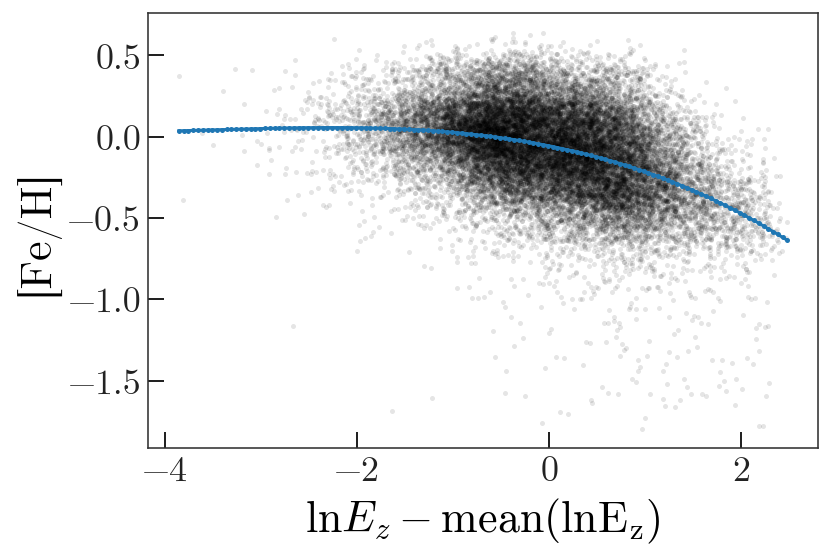

In [11]:
pot0 = Sech2Potential(Sigma=np.exp(lnsigma)*u.Msun/u.pc**2,
                      hz=np.exp(lnhz)*u.pc, units=usys)
Ez = (0.5*galcen.v_z**2 + pot0.energy(galcen.z[None])) / 1000.

x = np.log(Ez.value)
x = x - np.mean(x)

plt.plot(x, g.fe_h, marker='.', 
         ls='none', color='k', alpha=0.1)

mu_func = np.poly1d(alpha)

grid = np.linspace(x.min(), x.max(), 128)
plt.plot(grid, mu_func(grid))
plt.xlabel(r'$\ln E_z-\rm{mean}(\ln E_z)$')
plt.ylabel('[Fe/H]')

Text(0.5,0,'$\\Sigma$ [$\\mathrm{M_{\\odot}\\,pc^{-2}}$]')

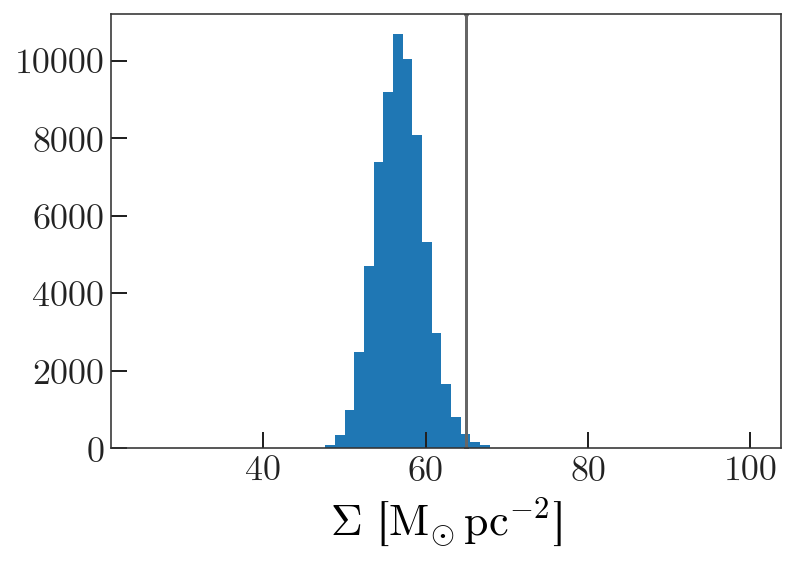

In [16]:
plt.hist(np.exp(sampler.flatchain[..., 2]), 
         bins=np.linspace(25, 100, 64));
plt.axvline(65.)
plt.xlabel(r'$\Sigma$ [{:latex_inline}]'.format(u.Msun/u.pc**2))